In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from natsort import natsorted
import scipy.signal as sig

### def read_image_directory()
directory = 'PIVimages/crosscorrelation'
prefix = None
type = 'png'

# Get a list of files in the directory
files = os.listdir(directory)

# If a prefix is specified, filter the list of files
if prefix is not None:
    files = [f for f in files if f.startswith(prefix)]
    
# If a type is specified, filter the list of files
if type is not None:
    files = [f for f in files if f.endswith(type)]
    
# Sort the files
files = natsorted(files)

# Read the images and store them in a list
images = [cv.imread(os.path.join(directory, f), 
                    cv.IMREAD_GRAYSCALE) for f in files]

In [2]:
# Count the number of images, make sure only two go to the next function
# Divide into interrogation windows

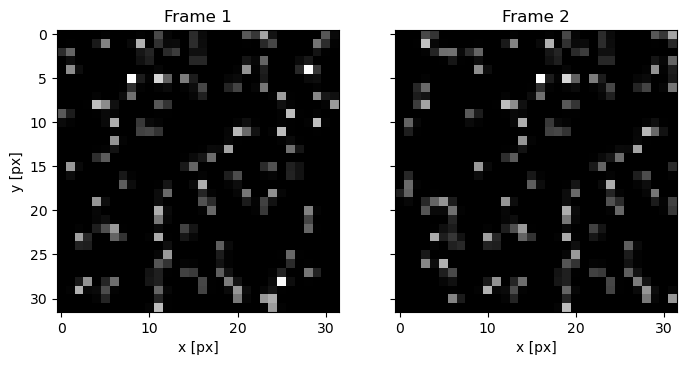

In [3]:
# Check the images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(images[0], cmap='gray')
ax[1].imshow(images[1], cmap='gray')

ax[0].set_title('Frame 1')
ax[1].set_title('Frame 2')
ax[0].set_xlabel('x [px]')
ax[0].set_ylabel('y [px]')
ax[1].set_xlabel('x [px]')
ax[1].set_yticklabels([])
plt.show()

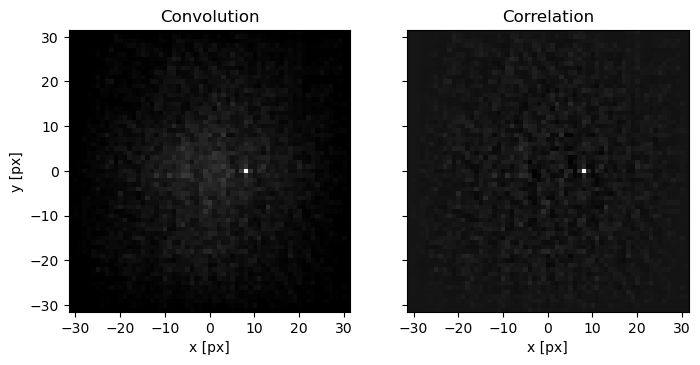

In [4]:
# Calculate the cross-correlation between the two images

# See the documentation of the function here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html#scipy.signal.convolve

### def cross_correlation(image1, image2, window_size)

convolution = sig.fftconvolve(images[1], images[0][::-1, ::-1])
correlation = sig.correlate(images[1] - np.mean(images[1]),
                            images[0] - np.mean(images[0]))

extent_array = [[-img.shape[1] + 0.5, img.shape[1] - 0.5, -img.shape[0] + 0.5,
                 img.shape[0] - 0.5] for img in images]

# Plot both methods to compare
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(convolution, cmap='gray', interpolation='none',
             extent=extent_array[0]) 
ax[1].imshow(correlation, cmap='gray', interpolation='none',
             extent=extent_array[1])

for a in ax:
    # Ticks every ten pixels
    a.set_xticks(np.arange(-30, 31, 10))
    a.set_yticks(np.arange(-30, 31, 10))

ax[0].set_title('Convolution')
ax[1].set_title('Correlation')
ax[0].set_xlabel('x [px]')
ax[0].set_ylabel('y [px]')
ax[1].set_xlabel('x [px]')
ax[1].set_yticklabels([])
plt.show()

In [15]:
## def find_displacement

# Calculate the maximum value of the cross-correlation
maximum = np.argwhere(np.amax(correlation) == correlation)

# TODO: can be made faster with https://stackoverflow.com/a/58652335

# If multiple maxima were found...
if len(maximum) > 1:
    # Error
    raise ValueError('Multiple equal maxima found in cross-correlation')
    # TODO: Handle multiple (neighbouring) maxima, if necessary
else:
    # Take the first value if only one maximum was found
    maximum = maximum[0]

In [29]:
surround = [correlation[(maximum[0] - 1):(maximum[0] + 2), maximum[1]],
                   correlation[maximum[0], (maximum[1] - 1):(maximum[1] + 2)]]

## def subpixel_refinement
# TODO: More sophisticated subpixel refinement

subpixel_correction = [(0.5 * (np.log(surround[0][0]) - np.log(surround[0][2]))
                       / ((np.log(surround[0][0])) + np.log(surround[0][2]) - 
                       2 * np.log(surround[0][1]))),
                       (0.5 * (np.log(surround[1][0]) - np.log(surround[1][2]))
                       / ((np.log(surround[1][0])) + np.log(surround[1][2]) - 
                       2 * np.log(surround[1][1])))]

In [30]:
# Process maximum
# Subtract the image centre to get relative coordinates
image_centre = np.array(images[0].shape) - np.ones(2)
maximum = maximum - image_centre

# Swap the axes to get the displacement in x and y
maximum = np.array(maximum[::-1])

# Same for the subpixel correction
subpixel_correction = np.array(subpixel_correction[::-1])

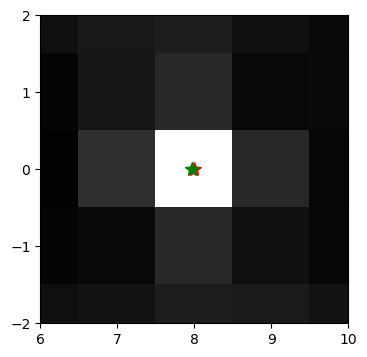

In [32]:
# Plot the cross-correlation with the maximum value
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(correlation, cmap='gray', interpolation='none', extent=extent_array[1])

# Plot the maximum value as a red star
ax.plot(*maximum, 'r*', markersize=10)

# Plot the subpixel-corrected value as a green star
ax.plot(*(maximum + subpixel_correction), 'g*', markersize=10)

# Zoom in around the maximum value
ax.set_xlim(maximum[0] - 2, maximum[0] + 2)
ax.set_ylim(maximum[1] - 2, maximum[1] + 2)

# Ticks every pixel
ax.set_xticks(np.arange(-2, 3, 1) + maximum[0]) 
ax.set_yticks(np.arange(-2, 3, 1) + maximum[1])

plt.show()

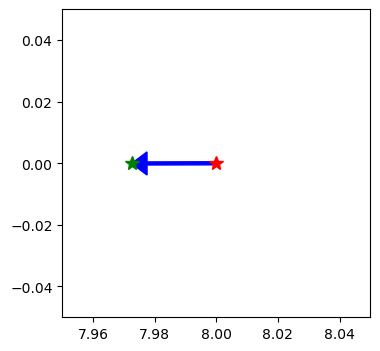

In [56]:
# Plot the cross-correlation with the maximum value
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(correlation, cmap='gray', interpolation='none', extent=extent_array[1])

# Plot the maximum value as a red star
ax.plot(*maximum, 'r*', markersize=10)

# Plot the subpixel-corrected value as a green star
ax.plot(*(maximum + subpixel_correction), 'g*', markersize=10)

# Zoom in around the maximum value
ax.set_xlim(maximum[0] - 0.05, maximum[0] + 0.05)
ax.set_ylim(maximum[1] - 0.05, maximum[1] + 0.05)

# Plot an arrow connecting the maximum and the subpixel-corrected value
ax.arrow(*maximum, *subpixel_correction, length_includes_head = True,
         color='b', head_width=0.0075, head_length=0.005)
plt.show()